### Using transfer learning to recognize dog breeds (combine two pre-trained models)

In [1]:
import os
import sys
import time
import pickle

from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np

from functools import partial

from multiprocessing import Pool

from skimage import io
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras 

from keras.layers import Concatenate, Merge, Input
from keras.models import Sequential, Model
from keras.layers.pooling import GlobalAveragePooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate


from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50

from script.image import load_train_resized

import matplotlib
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
labels_df = pd.read_csv('labels.csv')
print(labels_df.shape)

(10222, 2)


Load images on multiple threads, the loading method has to be defined outside the notebook or it does not work.  
It also scales images to (299, 299, 3) as the Inception model expects.  

In [3]:
def load_images(folder, names, h, w):
    load_image = partial(load_train_resized, folder=folder, h=h, w=w)
    
    with Pool(6) as p:
        rs = p.map_async(load_image, names)
        p.close()
        while (True):
            if (rs.ready()): break
            remaining = rs._number_left
            print("Waiting for", remaining, "tasks to complete...")
            time.sleep(10)
    print('Finished loading images...')
    
    images = []
    for r in rs.get():
        images.append(r)
    return np.asarray(images)

In [4]:
train_ids = list(labels_df.id)
train_features = load_images('train', train_ids, 299, 299)
print('Features shape ', train_features.shape)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 6 tasks to complete...
Waiting for 6 tasks to complete...
Finished loading images...
Features shape  (10222, 299, 299, 3)


In [5]:
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(labels_df.breed)
print('Labels shape ', labels.shape)

Labels shape  (10222, 120)


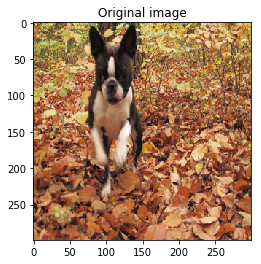

In [6]:
plt.imshow(train_features[0])
plt.title('Original image')

In [7]:
train_features_mean = np.mean(train_features, axis=(0))
print(train_features_mean.shape)

(299, 299, 3)


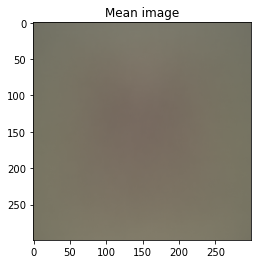

In [8]:
plt.imshow(train_features_mean)
plt.title('Mean image')

In [9]:
train_features_centered = train_features - train_features_mean

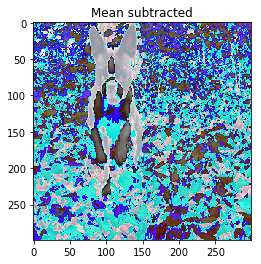

In [10]:
plt.imshow(train_features_centered[0])
plt.title('Mean subtracted')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    train_features_centered, labels, test_size=0.20, stratify = labels_df.breed, random_state = 442)

In [12]:
print('Train label matrix shape:', y_train.shape)
print('Train predictor matrix shape:', X_train.shape)
print('Test label matrix shape:', y_test.shape)
print('Test predictor matrix shape:', X_test.shape)

Train label matrix shape: (8177, 120)
Train predictor matrix shape: (8177, 299, 299, 3)
Test label matrix shape: (2045, 120)
Test predictor matrix shape: (2045, 299, 299, 3)


#### Combination of two pre-trained models
Will it improve the predictions?

In [13]:
input_shape=(299, 299, 3)
inputs = Input(shape=input_shape)

In [14]:
cnn1 = ResNet50(weights='imagenet', input_shape=input_shape, input_tensor = inputs, include_top = False)

for layer in cnn1.layers[:-1]:
    layer.trainable = False
    
x1 = cnn1.output
x1 = GlobalAveragePooling2D()(x1)

In [15]:
cnn2 = InceptionV3(weights='imagenet', input_shape=input_shape, input_tensor = inputs, include_top = False)

for layer in cnn2.layers[:-1]:
    layer.trainable = False

x2 = cnn2.output
x2 = GlobalAveragePooling2D()(x2)

Each model output (batch size, 2048) tensors, here we combine them into one (batch size, 4096) tensor and build 3 dense layers on top of it.

In [16]:
x = concatenate([x1, x2])

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(120, activation="softmax")(x)

c_model = Model(inputs = inputs, outputs = predictions)
c_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 150, 150, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 150, 150, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 150, 150, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

conv2d_92 (Conv2D)               (None, 8, 8, 384)     442368      activation_140[0][0]             
____________________________________________________________________________________________________
conv2d_93 (Conv2D)               (None, 8, 8, 384)     442368      activation_140[0][0]             
____________________________________________________________________________________________________
average_pooling2d_9 (AveragePool (None, 8, 8, 2048)    0           mixed9[0][0]                     
____________________________________________________________________________________________________
bn5c_branch2c (BatchNormalizatio (None, 10, 10, 2048)  8192        res5c_branch2c[0][0]             
____________________________________________________________________________________________________
conv2d_86 (Conv2D)               (None, 8, 8, 320)     655360      mixed9[0][0]                     
___________________________________________________________________________________________

Load weights from the previous training sessions.

In [17]:
filepath="c_weights.hdf5"
if os.path.exists(filepath):
    c_model.load_weights(filepath)

Prepare data generators.  
Use image augmentation on the training data.

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

In [19]:
test_datagen = ImageDataGenerator()
test_datagen.fit(X_test)

In [20]:
batch_size = 128
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [21]:
c_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [22]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, verbose = 0, mode = 'auto')
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [23]:
c_history = c_model.fit_generator(
    train_generator,
    steps_per_epoch=9199/batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=1023/batch_size,
    callbacks = [earlyStopping, checkpoint],
    verbose = 1
)

Epoch 1/100
72/71 [==============================] - 358s - loss: 3.9956 - acc: 0.1767 - val_loss: 2.2323 - val_acc: 0.6045
Epoch 2/100
72/71 [==============================] - 335s - loss: 2.0746 - acc: 0.4607 - val_loss: 1.1774 - val_acc: 0.6504
Epoch 3/100
72/71 [==============================] - 331s - loss: 1.6693 - acc: 0.5454 - val_loss: 0.9825 - val_acc: 0.7070
Epoch 4/100
72/71 [==============================] - 330s - loss: 1.4723 - acc: 0.5909 - val_loss: 0.9408 - val_acc: 0.7188
Epoch 5/100
72/71 [==============================] - 332s - loss: 1.3649 - acc: 0.6188 - val_loss: 0.9801 - val_acc: 0.7091
Epoch 6/100
72/71 [==============================] - 326s - loss: 1.3025 - acc: 0.6427 - val_loss: 1.0498 - val_acc: 0.7003
Epoch 7/100
72/71 [==============================] - 327s - loss: 1.2190 - acc: 0.6515 - val_loss: 1.0127 - val_acc: 0.7023
Epoch 8/100
72/71 [==============================] - 326s - loss: 1.1483 - acc: 0.6711 - val_loss: 1.0871 - val_acc: 0.6709
Epoch 9/

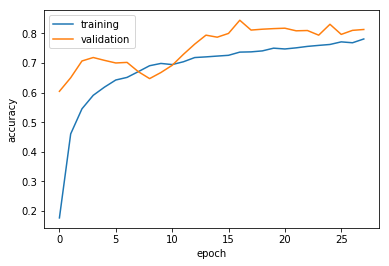

In [24]:
plt.plot(c_history.history['acc'], label='training')
plt.plot(c_history.history['val_acc'], label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

Out training accuracy is imporving fast while the va;lidation accuracy lags behind. It might be s sign of the overfitting.

In [26]:
y_pred_proba = c_model.predict(X_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1

In [27]:
print(classification_report(y_test, y_pred_test, target_names = binarizer.classes_))

                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.75      0.86        16
                  afghan_hound       0.92      1.00      0.96        23
           african_hunting_dog       0.94      1.00      0.97        17
                      airedale       0.91      0.95      0.93        22
american_staffordshire_terrier       0.73      0.53      0.62        15
                   appenzeller       0.60      0.56      0.58        16
            australian_terrier       0.87      0.62      0.72        21
                       basenji       0.95      0.95      0.95        22
                        basset       0.78      0.88      0.82        16
                        beagle       0.77      0.95      0.85        21
            bedlington_terrier       0.94      0.94      0.94        18
          bernese_mountain_dog       1.00      0.87      0.93        23
       black-and-tan_coonhound       0.93      0.87      0.90  

Does not look better than the inception V3 based model.

Prepare data for the Kaggle submission

In [28]:
test_ids = [ os.path.splitext(f)[0] for f in listdir('test') if isfile(join('test', f))]
test_features = load_images('test', test_ids, 299, 299)
print('Features shape ', test_features.shape)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 23 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 16 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 10 tasks to complete...
Waiting for 6 tasks to complete...
Waiting for 4 tasks to complete...
Finished loading images...
Features shape  (10357, 299, 299, 3)


In [29]:
test_features_mean = np.mean(test_features, axis=(0))
print(test_features_mean.shape)

(299, 299, 3)


In [30]:
test_features_centered = test_features - test_features_mean

In [31]:
y_pred_proba = c_model.predict(test_features_centered)

In [32]:
output_df = pd.DataFrame(y_pred_proba)
output_df.columns = binarizer.classes_
output_df.insert(loc=0, column='id', value=test_ids)
output_df.reset_index(drop=True, inplace=True)
output_df.to_csv('c_pred.csv',  index=False, float_format='%.7f')

Scored a bit lower than the inception V3 model on Kaggle.